# Sandbox/demo to go along with the MD assignment and lectures
## PharmSci 275

### Here, let's play with a very simple model system
In the MD assignment, we will be looking at a very simple polymer model. But here, let's backtrack to simple Lennard-Jones spheres and look at what happens if we run a simple dynamics calculation on a couple of particles subject to this potential, which will allow us to get a feel for how the integrator works.

Remember, for a Lennard-Jones system, the dimensionless form of our potential is 
\begin{equation}
U^* = \sum \limits_{i} 4\left( r_{ij}^{-12} - r_{ij}^{-6}\right) 
\end{equation}

which we can easily graph to get a sense of what will happen.

### We graph the potential for a pair of particles:

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in subtract


(-2, 2)

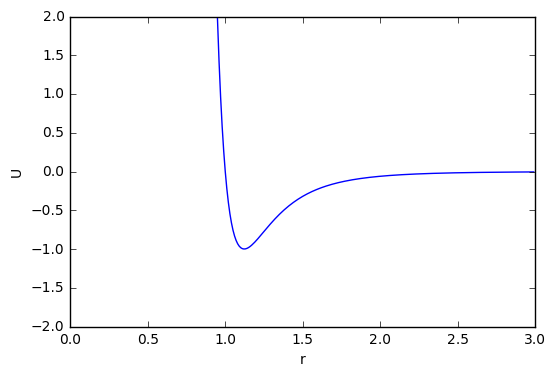

In [3]:
#Get pylab ready for plotting in this notebook - "magic" command specific for iPython notebooks
%pylab inline
#Import numpy
import numpy as np

#Generate array of distances to graph at
r = np.arange( 0,3, 0.01)

#Calculate U
U = 4.*(r**(-12.) - r**(-6.))

#Graph
plot( r, U, 'b-')
#Label x and y axes
xlabel('r')
ylabel('U')
#Adjust y limits not to be auto-scaled; since this goes to infinity at zero, the graph will not be useful unless we truncate
ylim(-2,2)


## Now, let's run some dynamics on a pair of particles subject to this potential


Here I've written a modified mdlib.f90 called md_sandbox.f90. Compile it as usual (with f2py) into md_sandbox (e.g. `f2py -c -m md_sandbox md_sandbox.f90` or similar) so that you can import it below. The difference between this and mdlib is that I've removed the bonds between atoms, so that we have simple Lennard-Jones particles rather than LJ polymers.

### First, we set up our system:

In [63]:
#Let's define the variables we'll need
dt = 0.001
Cut = 2.5
L = 10 #Let's just put these in a fairly big box so we have room
M = 1 #Here this doesn't actually do anything, but I didn't remove it from the functions

#Import our library
from md_sandbox import *

#Choose N for number of particles
N = 2

#Allocate position array - initially just zeros
Pos = np.zeros((N,3), float)

#In this case, place two LJ particles at specified initial positions - chosen so they are relatively near each other
#If you had more than two particles you'd need to adjust this
Pos[0,:] = np.array([0,0,0])
Pos[1,:] = np.array([1.1,0,0]) # Try comparing a starting distance of 1.1 with 1.5. Which looks more harmonic? Why?
#Might be worth experimenting to see what happens if we randomly place the particles instead


#Assign initial velocities - in this case I'll start off with them stationary and see what happens
Vel = np.array([[0,0,0],[0,0,0]], float)
#You could tweak the initial velocities to see what happens under different conditions

## Before we do any dynamics, notice that this is really a 1D system, so let's write a function to compute r, which we will store later

In [64]:
def get_r(Pos):
    """Calculate r, the distance between particles, for a position array containing just two particles. Return it."""
    
    #Get displacement
    dist = Pos[1,:] - Pos[0,:]
    #Calculate distance and return
    return np.sqrt( np.dot( dist, dist))

## OK, now let's start doing some dynamics

We're going to want to store the distance between the two particles as a function of time, so we can graph it. We also might want to look at the population of each distance as a function of time and see how that compares with the energy landscape. Though, right now that's a little premature. Let's just start off by taking a few timesteps and see how the distance changes. 

In [68]:
#Define storage for positions at each time so we can track them
max_steps = 1000 #Maximum number of steps we will take - so we know how many positions we might store
Pos_t = np.zeros(( N,3,max_steps), float)

#Store initial positions
Pos_t[:,:,0] = Pos

#Make up initial forces
Forces = np.zeros((N,3), float)

#Kick things off by calculating energy and forces
energy, Forces = calcenergyforces( Pos, M, L, Cut, Forces )

#Take a timestep
Pos, Vel, Accel, KEnergy, PEnergy = vvintegrate( Pos, Vel, Forces, M, L, Cut, dt )

#Store new positions
Pos_t[:,:,1] = Pos

#Print original and current distance
for i in range(0,2):
    print(get_r(Pos_t[:,:,i]))

1.1130338943
1.11279841411


## What should the long-time behavior of this system be?

Before going on to the step below, think for a minute about what motion these particles should exhibit on long timescales and what it would look like if you've graphed it.

Once you've done so, write a `for` loop to run over max_steps and at each step, update the energy and forces, take a timestep, and store the new positions.

In [69]:
for i in range(max_steps):
    energy, Forces = calcenergyforces( Pos, M, L, Cut, Forces )
    Pos, Vel, Accel, KEnergy, PEnergy = vvintegrate( Pos, Vel, Forces, M, L, Cut, dt )
    Pos_t[:,:,i] = Pos

## Once you've done that, use this code to graph r versus time for your particles

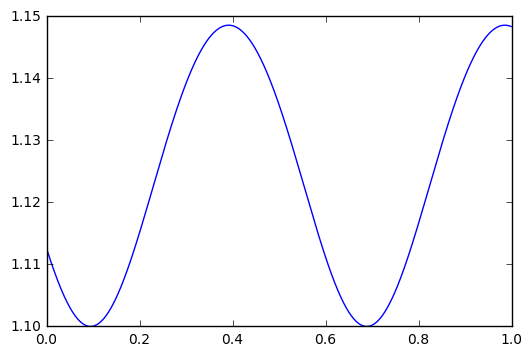

In [70]:
#Find x axis (time values)
t = dt*np.arange(0,max_steps)
#Find y axis (r values)
r_vs_t = []
for i in range(max_steps):
    r=get_r(Pos_t[:,:,i])
    r_vs_t.append(r)

r_vs_t = np.array(r_vs_t)

    
#Plot
figure()
plot(t, r_vs_t)
    